In [1]:
import tensorflow as tf

2025-10-08 15:41:33.530205: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 15:41:33.595861: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-08 15:41:36.391831: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [69]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

![Screenshot From 2025-10-08 15-50-48.png](<attachment:Screenshot From 2025-10-08 15-50-48.png>)
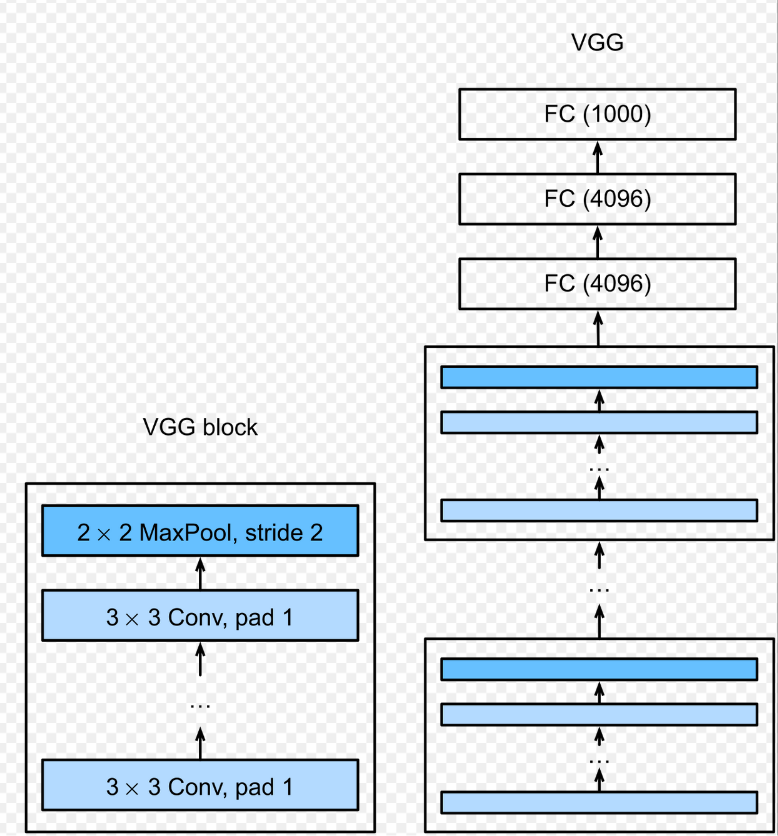

In [70]:
def vgg_block(num_conv, num_channels):
    blk = tf.keras.models.Sequential()
    for i in range(num_conv):
        blk.add(tf.keras.layers.Conv2D(num_channels, kernel_size=3, padding='same', activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk


In [78]:
class VGG(tf.keras.Model):
    def __init__(self, arch, num_classes=10):
        super().__init__()
        self.arch = arch
        self.num_classes= num_classes
        self.net = tf.keras.models.Sequential()
        for (num_conv, num_channels) in arch:
            self.net.add(vgg_block(num_conv, num_channels))
        self.net.add(
            tf.keras.models.Sequential([
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(4096, activation='relu'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(4096, activation='relu'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(10)
            ]))
    def call(self, x):
        return self.net(x)

The original VGG network had five convolutional blocks, among which the first two have one convolutional layer each and the latter three contain two convolutional layers each. The first block has 64 output channels and each subsequent block doubles the number of output channels, until that number reaches 512. Since this network uses eight convolutional layers and three fully connected layers, it is often called VGG-11.

In [96]:
#vgg_11 = VGG(arch=((1,64), (1,128), (2,256), (2,512), (2,512))) the original vgg
vgg_mini = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128))) #using a small network due to computational constraint

In [109]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, axis=-1)
    image = tf.image.resize(image, [224, 224])
    return image, label

batch_size = 18

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess) \
                   .shuffle(buffer_size=1024) \
                   .batch(batch_size) \
                   .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess) \
                   .shuffle(buffer_size=1024) \
                   .batch(batch_size) \
                   .prefetch(tf.data.AUTOTUNE)

In [110]:
#Manual training loop
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    total_loss = 0.0
    train_acc_metric.reset_state()
    num_batches = 0    

    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
        with tf.GradientTape() as t:
            logits = vgg_mini(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = t.gradient(loss_value, vgg_mini.trainable_variables)
        optimizer.apply_gradients(zip(grads, vgg_mini.trainable_variables))

        total_loss += loss_value.numpy()
        train_acc_metric.update_state(y_batch_train, logits)
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_acc = train_acc_metric.result().numpy()
    
    print(f" Training Loss: {avg_loss}")
    print(f" Accuracy: {avg_acc}")




Epoch 1/10


2025-10-08 16:42:53.845294: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 64.00MiB (rounded to 67108864)requested by op Cast
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-10-08 16:42:53.845323: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1049] BFCAllocator dump for GPU_0_bfc
2025-10-08 16:42:53.845328: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (256): 	Total Chunks: 91, Chunks in use: 89. 22.8KiB allocated for chunks. 22.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2025-10-08 16:42:53.845332: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (512): 	Total Chunks: 10, Chunks in use: 9. 5.8KiB allocated for chunks. 5.0KiB in use in bin. 3.9KiB client-requested in use in bin.
2025-10-08 16:

ResourceExhaustedError: {{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Cast] name: 